# Задание №5 (работы 9-10)

## Оптимизация функции

In [73]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
import warnings
import pandas as pd
from IPython import display

from scipy.optimize import newton
from pyswarm import pso


### Определение и визуализация функции

C:\Users\MPROKA~1\AppData\Local\Temp/ipykernel_38760/2397541791.py:31: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


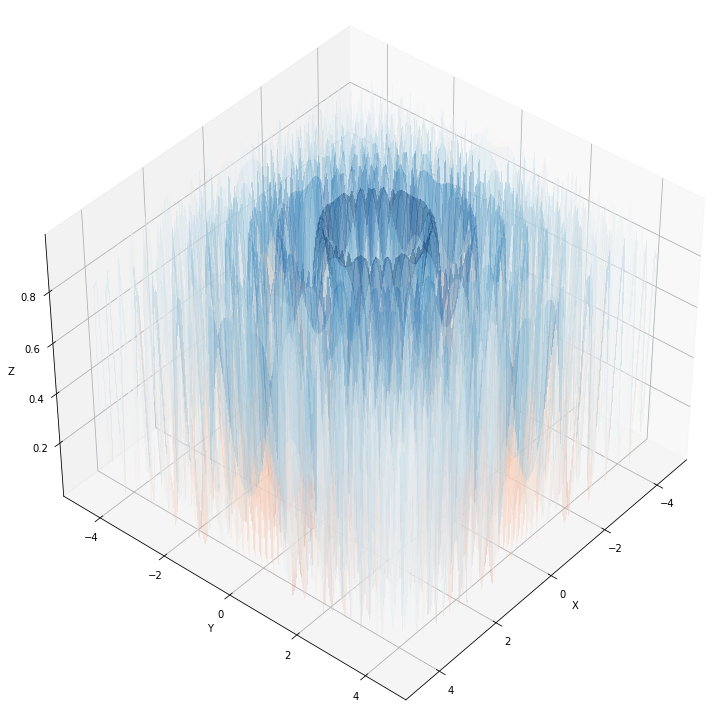

In [53]:
def McCormick(x, y):
    return np.sin(x + y) + ((x - y)**2) - 1.5 * x + 2.5 * y + 1

def ShafferN2(x, y):
    return 0.5 + ( (np.sin(x**2 + y**2))**2 - 0.5 ) / (1 + 0.001 * (x ** 2 + y ** 2))**2

func = lambda V: ShafferN2(V[0], V[1])

def plot_function(ax, function, variables, invert=False, colormap='coolwarm', rot_z=30, rot_xy=30, max_Z=None):
    cmap = plt.get_cmap(colormap)
    
    Z = np.clip(function(variables), 0, max_Z)
    
    if invert:
        Z = -Z
        
    ax.plot_surface(variables[0], variables[1], Z, cmap=cmap,
                           linewidth=0, antialiased=False, alpha=0.2)    

    ax.view_init(rot_z, rot_xy)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

x = np.linspace(-4.5, 4.5, 100)
y = np.linspace(-4.5, 4.5, 100)
xy = np.meshgrid(x, y)

fig = plt.figure(figsize=(13, 13))

ax = fig.gca(projection='3d')

plot_function(ax, func, xy, colormap='RdBu', rot_z=40, rot_xy=40)
plt.show()

### Оптимизация

#### Алгоритм Ньютона

In [62]:
%%time

x0 = np.array([-1, 1])
minV = newton(func, x0, maxiter=100)

f"{func(minV):.3f}", minV

Wall time: 7 ms


('0.000', array([ 3.56257107e-07, -3.56257107e-07]))

#### Алгоритм роя частиц

In [64]:
%%time

lb = [-1, -1]
ub = [1, 1]

minV, _ = pso(func, lb, ub, minfunc=1e-18, minstep=1e-18, maxiter=100, swarmsize=200, debug=False)
f"{func(minV):.3f}", minV


Stopping search: maximum iterations reached --> 100
Wall time: 520 ms


('0.000', array([3.17952817e-07, 3.70032215e-09]))

### Оценка времени и точности

In [83]:
coordinates, found_min, elapsed = [], [], []

for _ in range(100):
    started = time.time()
    minV, min = pso(func, lb, ub, minfunc=1e-17, minstep=1e-9, maxiter=100, swarmsize=50, debug=False)
    elapsed.append(time.time() - started)
    coordinates.append(minV)
    found_min.append(min)

display.clear_output()
pd.DataFrame({
    "Величина" : ["Время", "Экстремум"], 
    "Ожидание": [np.mean(elapsed), np.mean(found_min)],
    "Дисперсия": [np.var(elapsed), np.var(found_min)]})

,Величина,Ожидание,Дисперсия
0,Время,0.133128,0.000024
1,Экстремум,0.000000,0.000000


### Визуализация функции соответствия

C:\Users\MPROKA~1\AppData\Local\Temp/ipykernel_38760/1508171123.py:29: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
c:\Users\mprokazin\source\repos\data_science\env\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:137: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  position3d = np.array((self._x, self._y, self._z))
c:\Users\mprokazin\source\repos\data_science\env\lib\site-packages\mpl_toolkits\mplot3d

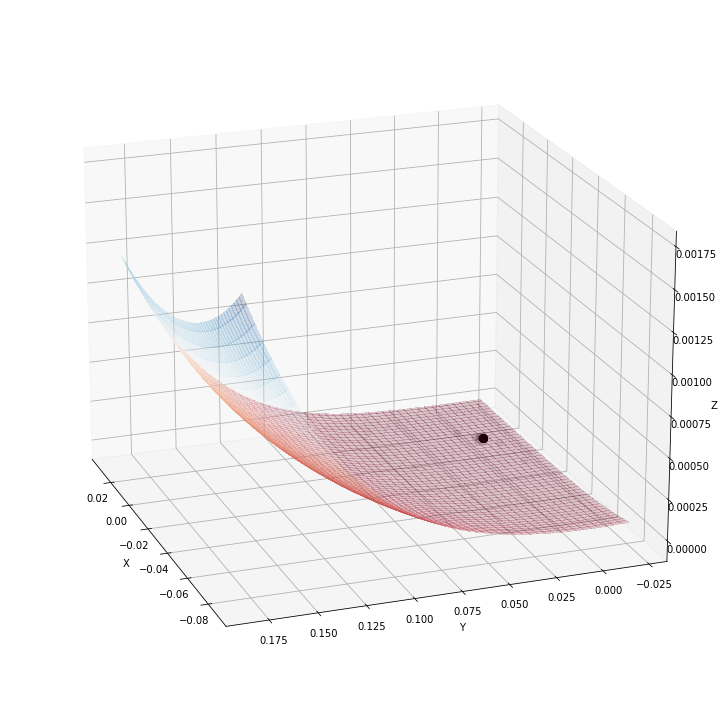

In [94]:
coordinates = []

for maxiter in range(100):
    minV, _ = pso(func, lb, ub, minfunc=1e-17, minstep=1e-9, maxiter=maxiter, swarmsize=50, debug=False)
    coordinates.append(minV)
np_coordinates = np.array(coordinates)

display.clear_output()

x_min, y_min = np.min(np_coordinates, axis=0)
x_max, y_max = np.max(np_coordinates, axis=0)
x = np.linspace(x_min, x_max, 100)
y = np.linspace(y_min, y_max, 100)
xy = np.meshgrid(x, y)

n = 100

fig = plt.figure(figsize=(13, 13))

values = []
ax = plt.subplot(projection='3d')
for i, maxiter in zip(range(100), range(100)):
    point = np.meshgrid(np_coordinates[i][0], np_coordinates[i][1])
    point_value = func(point)
    values.append(point_value)  
    ax.scatter(point[0], point[1], point_value, s=50, c='black', alpha=maxiter/n)
    ax.text(np_coordinates[i][0], np_coordinates[i][1], point_value+1e-2, f'({np_coordinates[i][0]:.2f}, {np_coordinates[i][1]:.2f}, {point_value[0][0]:.4f})', zdir='z')

ax = fig.gca(projection='3d')
plot_function(ax, func, xy, colormap='RdBu', rot_z=20, rot_xy=160)
plt.show()

## Оптимизация параметров классификатора

### Загрузка данных

In [102]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('./data/ionosphere.data', header=None) # Load data

train, test = train_test_split(data, test_size=0.3)
X_train, y_train = train[range(0, 34)], train[34]
X_test, y_test = test[range(0, 34)], test[34]

X_train.head()


,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
319,1,0,0.85013,0.01809,0.92211,0.01456,0.92046,0.02180,0.92765,0.08010,...,0.83721,0.10853,0.86923,0.08950,0.87597,0.08786,0.85198,0.10134,0.84258,0.10698
290,1,0,0.47337,0.19527,0.06213,-0.18343,0.62316,0.01006,0.45562,-0.04438,...,0.47929,-0.02367,0.46514,0.03259,0.53550,0.25148,0.31953,-0.14497,0.34615,-0.00296
316,1,0,0.89589,0.39286,0.66129,0.71804,0.29521,0.90824,-0.04787,0.94415,...,0.21581,-0.85703,0.53229,-0.68593,0.74846,-0.40656,0.83142,-0.07029,0.76862,0.27926
33,1,0,0.71253,-0.02595,0.41287,-0.23067,0.98019,-0.09473,0.99709,-0.10236,...,0.65493,-0.20392,0.93124,-0.41307,0.63811,-0.21901,0.86136,-0.87354,-0.23186,-1.00000
77,0,0,1.00000,1.00000,1.00000,-1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,-1.00000,1.00000,1.00000,-1.00000,1.00000,-1.00000,-1.00000,-1.00000,1.00000


In [133]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def score(classifier_type: type, input_vector_to_classifier_param_dict):
    def score_func(input_vector):
        params = input_vector_to_classifier_param_dict(input_vector)
        classifier = classifier_type(**params)
        classifier.fit(X_train, y_train)

        return 1 / classifier.score(X_test, y_test)
    return score_func

classifiers = [
    SVC,
    KNeighborsClassifier,
    RandomForestClassifier
]

bounds = [
    [[10, 4, 0], [30, 5, 3]],
    [[1, 5, 0], [5, 10, 2]],
    [[50, 0, 0 + 1e-20, 0 + 1e-20], [150, 2, 1, 0.5]]
]

input_vector_to_parameters = [
    lambda V: { "C": V[0], "degree": V[1], "kernel": ["linear", "rbf", "poly", "sigmoid"][int(V[2])]},
    lambda V: { "n_neighbors": int(V[0]), "leaf_size": int(V[1]), "metric": ["euclidean", "manhattan", "chebyshev" ][int(V[2])]},
    lambda V: { "n_estimators": int(V[0]), "max_features": ['auto', 'sqrt', 'log2'][int(V[1])], "min_samples_split": V[2], "min_samples_leaf": V[3]}
]

results = []

for classifier, bounds, param_func in zip(classifiers, bounds, input_vector_to_parameters):
    name = classifier.__name__
    score_func = score(classifier, param_func)
    minV, min = pso(score_func, bounds[0], bounds[1], maxiter=100)
    results.append({"Classifier": name, "Best params": param_func(minV), "Best accuracy": 1 / min})

pd.DataFrame(results)

Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100


,Classifier,Best params,Best accuracy
0,SVC,"{'C': 20.18470500258816, 'degree': 4.834615349...",0.962264
1,KNeighborsClassifier,"{'n_neighbors': 1, 'leaf_size': 7, 'metric': '...",0.952830
2,RandomForestClassifier,"{'n_estimators': 82, 'max_features': 'sqrt', '...",0.962264


In [134]:
print(results) # Печать полных результатов на всякий случай.

[{'Classifier': 'SVC', 'Best params': {'C': 20.18470500258816, 'degree': 4.834615349952651, 'kernel': 'rbf'}, 'Best accuracy': 0.9622641509433961}, {'Classifier': 'KNeighborsClassifier', 'Best params': {'n_neighbors': 1, 'leaf_size': 7, 'metric': 'chebyshev'}, 'Best accuracy': 0.9528301886792453}, {'Classifier': 'RandomForestClassifier', 'Best params': {'n_estimators': 82, 'max_features': 'sqrt', 'min_samples_split': 0.3074133376222997, 'min_samples_leaf': 0.06180131096426922}, 'Best accuracy': 0.9622641509433961}]
